# Initialization

## Required function, Imports

In [1]:
import filter_inversion as fi
import numpy as np
import pickle
import matplotlib.pyplot as plt
import csv
def voltage_time_figure_plot(X1, Y1, color_code, name):
    # Create figure
    figure1 = plt.figure(name)
    
    # Create axes
    axes1 = figure1.add_subplot(1, 1, 1)
    
    # Create plot
    axes1.plot(X1, Y1, linewidth=2, color=color_code)
    
    # Set ylabel
    axes1.set_ylabel('Voltage (mV)', fontsize=16.5)
    
    # Set xlabel
    axes1.set_xlabel('Time (s)', fontsize=16.5)
    
    # Set title
    axes1.set_title(name, fontsize=16.5)
    
    # Set x-axis limit
    # axes1.set_xlim([0, 0.000001])
    
    # Uncomment the following line to set y-axis limit
    # axes1.set_ylim([-60, 60])
    
    # Uncomment the following line to set z-axis limit
    # axes1.set_zlim([-1, 1])
    
    axes1.grid(True)
    axes1.set_axisbelow(True)
    axes1.tick_params(labelsize=15)
    
    # Show the plot
    plt.show()

def set_mean(input_array):
    return np.mean(input_array, axis=0)
def set_offset(input_array, adjust):
    return np.array(input_array) - input_array[0] * adjust
def set_gain(input_array, adjust):
    gain = np.max(input_array[1]) * adjust
    return np.array(input_array[1]) / gain

def read_filter_coef_csv():
    IIR_coef = []
    with open("IIR.csv") as csvfile:
        for row in csv.reader(csvfile):
            for coef in row:
                IIR_coef.append(float(coef))
    return IIR_coef

def set_gain_tail(waveform, time_point):
    time_point_index = np.where(np.array(waveform[0]) > time_point)[0][0]
    gain = np.abs(waveform[1][time_point_index])
    print("gain = {}".format(gain))
    print("waveform[1][time_point_index] = {}".format(np.array(waveform[1])[time_point_index]))
    print("np.array(waveform[1]) / gain = {}".format(np.array(waveform[1])[time_point_index] / gain))
    return np.array(waveform[1]) / gain

def moving_agerage(waveform,window_size ):
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []
    arr = np.array(waveform[1])
    # Loop through the array t o
    while i < len(arr) - window_size + 1:
    
        # Calculate the average of current window
        window_average = np.sum(arr[
        i:i+window_size]) / window_size
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        
        # Shift window to right by one position
        i += 1
    waveform[0] = np.array(waveform[0])[0 : len(arr) - window_size+1]
    waveform[1] = moving_averages
    
    return waveform

In [128]:
from NLab import*  ;
g= None ; 
from textwrap import dedent as dt
def load_g(macros=None):
    global g
    try:
        g.stop()
    except Exception:
        pass
    g = Root("localhost:7000", 20_000)
    if macros is not None:
        g.am(**macros)
    g.load_dir("settings")
    return g  ;

def na_only() : 
    global g ; 
    g.TRACE["X"] = "&instr-na-X" ; 
    g.TRACE["Y"] = "&instr-na-S21" ; 
    g["seq-cts"] =[]; # select no channels to send waves
    g.POINT= {}; 
    g.ACTIONS = []; 

def na_single_point() : 
    global g ; 
    g.POINT = {}; 
    g.POINT["Y"] = "np.mean(&instr-na-S21[-1])" ; 
    g["seq-cts"] =[]; # select no channels to send waves
    g.TRACE= {}; 
    g.ACTIONS = []; 

class EmptyClass()  :pass   
def load(path) : 
    W = EmptyClass(); 
    W.Dr = rwdata.load(path)  ; 
    W.D1 = W.Dr["LOG_0"] ; 
    W.V = W.D1["VOLS"] ; 
    W.D = W.D1["DATA_dim"] ; 
    return W ;

def spm(g,p) : g.SAVE_PATH_MNR = p ; 
import matplotlib.pyplot as plt ; 

In [2]:
pwd

'E:\\OP\\Experiments\\0616_2023_pred\\tools'

## Load full waveform

In [3]:
X,Y =  pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/BareAWGT_10rep_80G_80kpts_70us_LineCase2.pkl","rb"))

waveform = [X[0],set_mean(Y)]
waveform[0] = waveform[0]*10**(6)
waveform[1] = set_gain(waveform, 1)

waveform_record = []
waveform_record.append(waveform)
%matplotlib qt
voltage_time_figure_plot(waveform[0], waveform[1], 'green', 'The original waveform')

In [ ]:
waveform_AWG =  pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/BareAWGT_10rep_80G_80kpts_70us_LineCase2.pkl", "rb"))# moving_agerage(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/retest_500smooth_BareAWG_new_averaged.pkl", "rb")), window_size)
waveform_AWG[1] = set_mean(np.copy(waveform_AWG))
waveform_AWG[0] = waveform_AWG[0][0]
waveform_AWG = moving_agerage(waveform_AWG, window_size)
waveform_AWG[1] = set_offset(np.copy(waveform_AWG),1)
# waveform_AWG[1] = set_gain(np.copy(waveform_AWG),1)
waveform_AWG[1] = set_gain_tail(np.copy(waveform_AWG), time_point)

# IIR fitting & Inverse filtering

## First Fitting & Filtering

In [6]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 40.03
end_time = 42
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform))
voltage_time_figure_plot(waveform_segment[0], waveform_segment[1], 'blue', 'The selected waveform segment')

In [7]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'highpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
time_offset = start_time
amp_offset = 0.98106
coef_B = 1- amp_offset
coef_tau = 1e-2
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

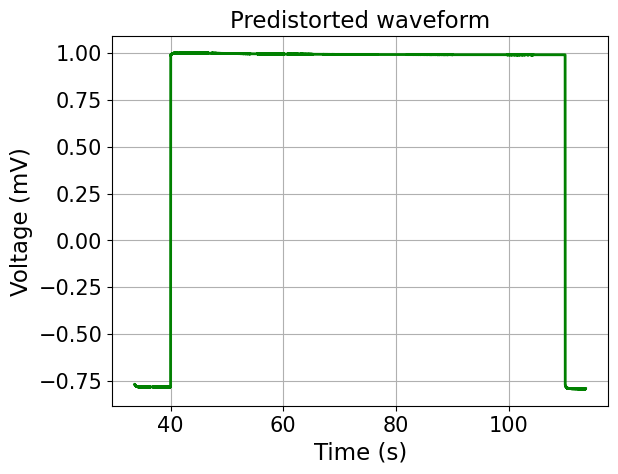

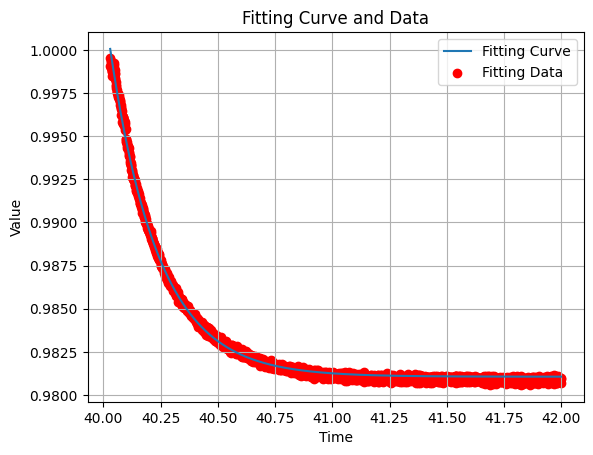

In [15]:
%matplotlib inline
waveform_pred_1st = fi.predistor(np.copy(waveform), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1st)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_1st[0], waveform_pred_1st[1], 'green', 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/IIR_data/IIR_high_1st.pkl" , "wb"))

In [13]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/IIR_data/IIR_high_1st.pkl", "rb"))

[1.0, 0.9999662290561695, 0.9953753184881363, -0.9952522650663385]

In [32]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/IIR_data/IIR_high_1st.pkl", "rb")))  - np.array([1,1,1,-1])

array([ 0.00000000e+00, -3.37709438e-05, -4.62468151e-03,  4.74773493e-03])

## Second Fitting & Filtering

In [23]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 43.482
end_time = 109.99
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform_pred_1st))

%matplotlib qt
voltage_time_figure_plot(waveform_segment[0], waveform_segment[1], 'blue', 'The selected waveform segment')

In [25]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'highpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
time_offset = start_time
amp_offset = 0.9909
coef_B = 1.00- amp_offset
coef_tau = 1e-3
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

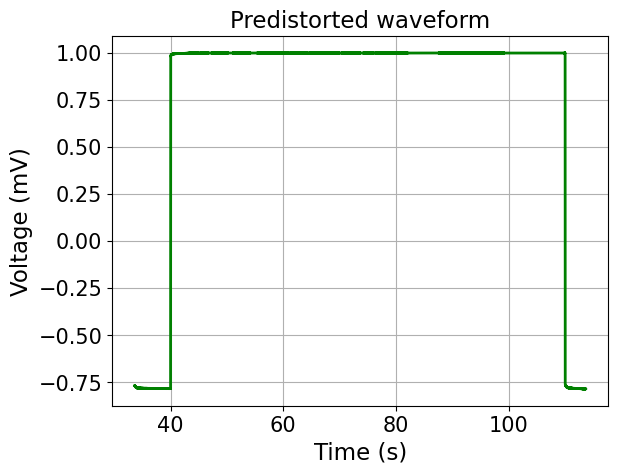

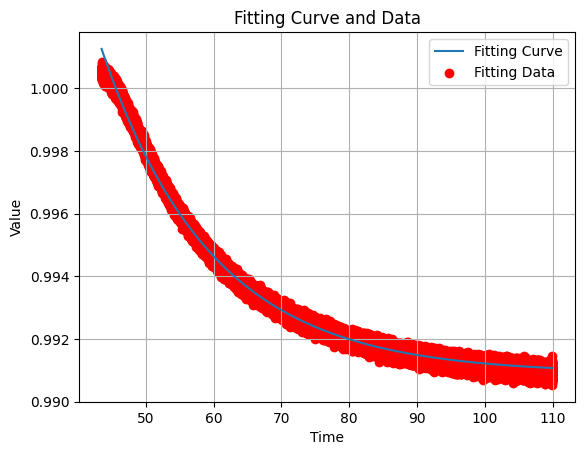

In [38]:
%matplotlib inline
waveform_pred_2nd = fi.predistor(np.copy(waveform_pred_1st), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_2nd)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_2nd[0], waveform_pred_2nd[1], 'green', 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/IIR_data/IIR_high_2nd.pkl" , "wb"))

In [29]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/IIR_data/IIR_high_2nd.pkl", "rb"))

[1.0, 0.9987379612981283, 0.9999390341563471, -0.9986764355703527]

In [34]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/IIR_data/IIR_high_2nd.pkl", "rb")))  - np.array([1,1,1,-1])

array([ 0.00000000e+00, -1.26203870e-03, -6.09658437e-05,  1.32356443e-03])

## Third Fitting & Filtering

In [46]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 40.02
end_time = 50
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform_pred_2nd))

%matplotlib qt
voltage_time_figure_plot(waveform_segment[0], waveform_segment[1], 'blue', 'The selected waveform segment')

In [107]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'lowpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
time_offset = start_time
amp_offset = 1
coef_B = - amp_offset
coef_tau = 7e-5
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

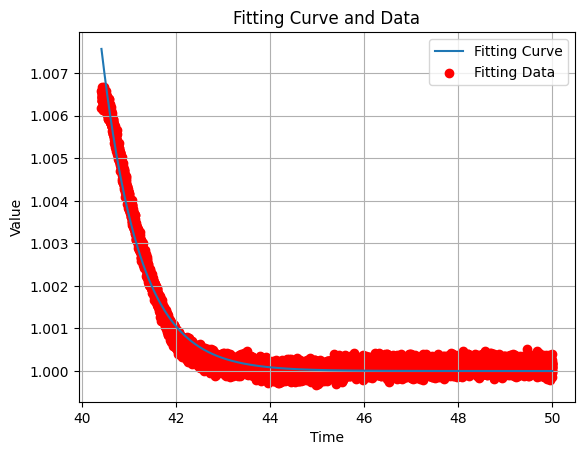

In [129]:
%matplotlib inline
waveform_pred_3rd = fi.predistor(np.copy(waveform_pred_2nd), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_3rd[0], waveform_pred_3rd[1], 'green', 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/IIR_data/IIR_high_3rd.pkl" , "wb"))

In [109]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/IIR_data/IIR_high_3rd.pkl", "rb"))

[1.0, 1.0091549680592855, 0.9992048830938924, -1.0083598511531782]

In [110]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/IIR_data/IIR_high_3rd.pkl", "rb")))  - np.array([1,1,1,-1])

array([ 0.        ,  0.00915497, -0.00079512, -0.00835985])

## Fourth Fitting & Filtering

In [117]:
"""
Select the start_time and end_time of you waveform that will be sent to the fitting process

Use the get_waveform_segment() to slice out your waveform to get the data segment
"""
start_time = 40.414
end_time = 50
waveform_segment = fi.get_waveform_segment(start_time, end_time, np.copy(waveform_pred_3rd))

%matplotlib qt
voltage_time_figure_plot(waveform_segment[0], waveform_segment[1], 'blue', 'The selected waveform segment')

In [118]:
"""
type: string
    'highpass': high-pass model fitting;
    'lowpass': low-pass model fitting;
    'line': linear model fitting;
    'skin': skin effect model fitting;
"""
type = 'highpass'
fs = 1 / (waveform[0][1] - waveform[0][0])
time_offset = start_time
amp_offset = 1 # 0.9975
coef_B = 1.00651 - amp_offset
coef_tau = 1e-2
param = [type, fs, coef_B, coef_tau, time_offset, amp_offset]

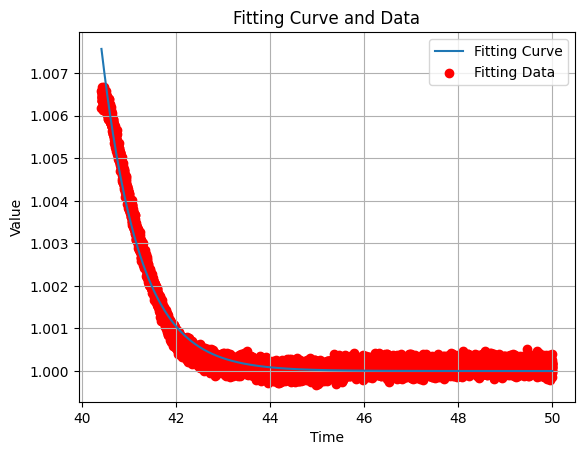

In [124]:
%matplotlib inline
waveform_pred_4th = fi.predistor(np.copy(waveform_pred_3rd), np.copy(waveform_segment), param)
# waveform_record.append(waveform_pred_1)

%matplotlib qt
voltage_time_figure_plot(waveform_pred_4th[0], waveform_pred_4th[1], 'green', 'Predistorted waveform')

IIR_coef = read_filter_coef_csv()
pickle.dump(IIR_coef , open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/IIR_data/IIR_high_4th.pkl" , "wb"))

In [125]:
# [a0, b0, a1, b1]
pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/IIR_data/IIR_high_4th.pkl", "rb"))

[1.0, 0.9924877548220641, 0.9987639794890205, -0.9912517343110847]

In [126]:
np.array(pickle.load(open("E:/OP/Experiments/0616_2023_pred/DATA/test/copper_line/IIR_data/IIR_high_4th.pkl", "rb")))  - np.array([1,1,1,-1])

array([ 0.        , -0.00751225, -0.00123602,  0.00874827])

# Collection of plot

In [8]:
# X_1stPred, Y_1stPred =  pickle.load(open("E:/OP/Experiments/0609_predistortion/DATA/test/test/retest_500smooth_BareAWG_1stPred.pkl","rb"))
X_2ndPred, Y_2ndPred =  pickle.load(open("E:/OP/Experiments/0609_predistortion/DATA/test/test/retest_500smooth_BareAWG_2ndPred.pkl","rb"))
# X_bare_new, Y_bare_new =  pickle.load(open("E:/OP/Experiments/0609_predistortion/DATA/test/test/retest_500smooth_BareAWG_new.pkl","rb"))

%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(X[0], np.mean(Y,axis = 0), label='Orignial ', color=  'blue')

# ax.plot(X_1stPred[0], np.mean(Y_1stPred, axis=0), label='First Predistorted', color=  'red')
# ax.plot(X_bare_new[0], np.mean(Y_bare_new, axis=0), label='Original new', color=  'red')

# ax.plot(X_2ndPred[0], np.mean(Y_2ndPred, axis = 0), label='First Predistorted', color = 'orange')

ax.grid()
    # Labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.set_title('Distorted vs. Filtered Waveform')

    # Legend
ax.legend()

    # Display the plot
plt.show()

array([2.0000e-05, 2.0001e-05, 2.0002e-05, ..., 9.9997e-05, 9.9998e-05,
       9.9999e-05])